# Decision Tree

1. **Aims and Objectives**

Following the exploratory data analysis and visualisations developed in Tableau, this section will  apply a supervised machine learning approach to predict the likelihood that a financial transaction is fraudulent. The model is trained on the pre-processed, labeled dataset, prepared in the `etl_process.ipynb` notebook. By using classification techniques, the goal is to identify key patterns and risk indicators that may signal potential money laundering or financial crime activity before the transaction occurs.

The workflow I will use for this supervised learning is
- Split the dataset into train and test set
- Fit the pipeline
- Evaluate your model. 

In [118]:
#step 0. Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

import warnings
warnings.filterwarnings('ignore')

1. **Import the data**


In [124]:
#Step 1. Load the dataset
data = pd.read_csv ('/Users/nataliewaugh/Documents/DataCode/Detecting_Money_Laundering_Patterns-/data/cleaned_money_laundering_datasetrevised.csv') 

#Step 2. show the first few rows of the dataset
data.head()

,Origin Country,Amount (USD),Transaction Type,Date of Transaction,Person Involved,Industry,Destination Country,Reported by Authority,Source of Money,Money Laundering Risk Score,Shell Companies Involved,Financial Institution,Tax Haven Country,Domestic or Cross-Border,Origin Country Category,Destination Tax Haven Flag
0,Brazil,3267530.0,Offshore Transfer,2023-01-01 00:00:00,Person_1101,Construction,USA,True,Illegal,6,1,Bank_40,Singapore,Cross-Border,Upper-Middle / Partial Regulated,Non-Tax Haven
1,China,4965767.0,Stocks Transfer,2023-01-01 01:00:00,Person_7484,Luxury Goods,South Africa,False,Illegal,9,0,Bank_461,Bahamas,Cross-Border,Upper-Middle / Partial Regulated,Non-Tax Haven
2,UK,94168.0,Stocks Transfer,2023-01-01 02:00:00,Person_3655,Construction,Switzerland,True,Illegal,1,3,Bank_387,Switzerland,Cross-Border,High Income / Regulated,Tax Haven
3,UAE,386420.0,Cash Withdrawal,2023-01-01 03:00:00,Person_3226,Oil & Gas,Russia,False,Illegal,7,2,Bank_353,Panama,Cross-Border,High Income / Tax Haven,Non-Tax Haven
4,South Africa,643378.0,Cryptocurrency,2023-01-01 04:00:00,Person_7975,Real Estate,USA,True,Illegal,1,9,Bank_57,Luxembourg,Cross-Border,Upper-Middle / Regulated,Non-Tax Haven


2. **Prepare the data**

Before feeding categorical data into most machine learning models, it must be converted into numerical format. For this project, I applied One-Hot Encoding, a technique that transforms each category into its own binary column. Initial attempts at encoding produced several errors due to residual string values remaining in the dataset. After iterative cleaning suggestions provided by AI and validation checks, the following version of the code successfully performed the transformation:

In [125]:
#Step 3 Drop columns that are not needed.
data = data.drop(columns=[
    'Date of Transaction',        
    'Person Involved',            
    'Financial Institution'        
])

In [126]:
#Step 4. Check data types.
print(data.dtypes)

Origin Country                  object
Amount (USD)                   float64
Transaction Type                object
Industry                        object
Destination Country             object
Reported by Authority             bool
Source of Money                 object
Money Laundering Risk Score      int64
Shell Companies Involved         int64
Tax Haven Country               object
Domestic or Cross-Border        object
Origin Country Category         object
Destination Tax Haven Flag      object
dtype: object


In [127]:
#Step 5. Encode all object and bool columns
data_encoded = pd.get_dummies(data, drop_first=True) 
#(drop_first=True: drops the first category in each column to avoid multicollinearity)

#Step 6 Show results of encoding# Check result
print(data_encoded.head())
print(data_encoded.dtypes)
print(data_encoded.shape)

   Amount (USD)  Reported by Authority  Money Laundering Risk Score  \
0     3267530.0                   True                            6   
1     4965767.0                  False                            9   
2       94168.0                   True                            1   
3      386420.0                  False                            7   
4      643378.0                   True                            1   

   Shell Companies Involved  Origin Country_China  Origin Country_India  \
0                         1                 False                 False   
1                         0                  True                 False   
2                         3                 False                 False   
3                         2                 False                 False   
4                         9                 False                 False   

   Origin Country_Russia  Origin Country_Singapore  \
0                  False                     False   
1             

This is an extra step to covert all boolean columns to integers. This will enable me to work with `pipeline` and `StandardScaler`. Ai has been used to resolve the challenges around preparing the data for the ML pipeline. 

In [128]:
# Step7. Convert all boolean columns to integers (True → 1, False → 0)
bool_cols = data_encoded.select_dtypes(include=['bool']).columns
data_encoded[bool_cols] = data_encoded[bool_cols].astype(int)

In [146]:
print(data_encoded.dtypes)

Amount (USD)                                                float64
Reported by Authority                                         int64
Money Laundering Risk Score                                   int64
Shell Companies Involved                                      int64
Origin Country_China                                          int64
Origin Country_India                                          int64
Origin Country_Russia                                         int64
Origin Country_Singapore                                      int64
Origin Country_South Africa                                   int64
Origin Country_Switzerland                                    int64
Origin Country_UAE                                            int64
Origin Country_UK                                             int64
Origin Country_USA                                            int64
Transaction Type_Cryptocurrency                               int64
Transaction Type_Offshore Transfer              

This now complete all the transformation of the data removing all categorical and boolean data.

In [ ]:
#step 7.0 Check the unique values in the 'Source of Money_Legal' column
print(data_encoded['Source of Money_Legal'].unique( ))   # unique labels after encoding (likely 0 and 1)
print(data_encoded['Source of Money_Legal'].value_counts())
print(data_encoded['Source of Money_Legal'].head(10))

[0 1]
Source of Money_Legal
0    7017
1    2983
Name: count, dtype: int64
0    0
1    0
2    0
3    0
4    0
5    1
6    1
7    0
8    0
9    0
Name: Source of Money_Legal, dtype: int64


The `Source of Money_Legal` is coded as follows;
- 0 = Illegal 
- 1 = Legal 

The data source has far more illegal transactions than legal. 


---

Now that the data set is fully numeric, we can proceed with the machine learning model.
- Split the dataset into train and test set
- Fit the pipeline
- Evaluate your model. 

In [151]:
#Step 8 define the target column. Is the money legal or illegal?
target_col = ['Source of Money_Legal']  

X = data_encoded.drop(columns=['Source of Money_Legal']) # Features (all columns except the target)
y = data_encoded['Source of Money_Legal']          # Target (what I am predicting)

In [152]:
# Step 9. Split the dataset into training and testing sets
# from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [134]:
# Step 10. Train a Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [135]:
#Step 11. Make predictions
y_pred = model.predict(X_test)

In [136]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.578

Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.69      0.69      1389
           1       0.31      0.32      0.32       611

    accuracy                           0.58      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.58      0.58      0.58      2000


Confusion Matrix:
 [[958 431]
 [413 198]]


- **Accuracy: 0.578**
This means 57.8% of all predictions were correct.
Which is good considering the context and the fact that the data show most illegal transactions are not being `Reported by Authority`The risk of legal transactions being flaggged as illegal is minimal in this context. 

- **Classification Report**


- **Illegal**
Precision (0.70): Of all predictions that were "0", 70% were correct. 
Recall (0.69): Of all actual "0" examples, the model correctly identified 69%.
F1-score (0.69): Balance between precision and recall — fairly high.
Support (1389): There were 1,389 actual examples of class 0 in the test set.

- **Legal**
Precision (0.31): Only 31% of the predictions for class 1/legal were correct.
Recall (0.32): It only correctly caught 32% of all actual class 1 cases.
F1-score (0.32): Very low — this shows the model struggles with identifying legal transactions.
Support (611): There were 611 actual class 1 cases.

- **Averages:**
Macro avg: Simple average across classes (treats each class equally). Shows both classes are not being predicted equally well.
Weighted avg: Accounts for the number of samples per class. The model is more influenced by class 0 because it has more samples.

- **Confusion Matrix Interpretation:**
958 True Negatives: Correctly predicted class 0.
198 True Positives: Correctly predicted class 1.
431 False Negatives: Actual class 0, but predicted as 1.
413 False Positives: Actual class 1, but predicted as 0.


---

Based on the fact we know that the model is skewing results because the data set is more heavily weighted to illegal transactions, I will try and balance it out. 

In [153]:
#step 12. Balance the dataset
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(
    class_weight='balanced',  
    random_state=42
)
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [154]:
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Accuracy: 0.5935

Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71      1389
           1       0.33      0.33      0.33       611

    accuracy                           0.59      2000
   macro avg       0.52      0.52      0.52      2000
weighted avg       0.59      0.59      0.59      2000


Confusion Matrix:
 [[983 406]
 [407 204]]


This change has made a marginal improvement to the predictions. 

Model Performance Summary
The classifier achieved an overall accuracy of 59.35%, meaning it correctly predicted the target class in just under 6 out of 10 cases.
Classification Report Breakdown:
Metric	Class 0 (Legal)	Class 1 (Illegal)	Notes
Precision	0.71	0.33	Precision for Class 0 is high, meaning most predictions of "legal" transactions are correct. Class 1 is lower, indicating more false positives.
Recall	0.71	0.33	The model is better at identifying legal transactions than illegal ones. Only 33% of illegal transactions were correctly flagged.
F1-Score	0.71	0.33	Balanced measure of precision and recall—again, Class 0 performs better.
Support	1389	611	There are significantly more legal (Class 0) transactions in the test set, making the dataset imbalanced.

 Confusion Matrix
               Predicted
               0     1
Actual  0    [983   406]
        1    [407   204]
True Positives (TP): 204 illegal transactions correctly identified
False Positives (FP): 406 legal transactions misclassified as illegal
False Negatives (FN): 407 illegal transactions missed
True Negatives (TN): 983 legal transactions correctly identified

Key Insight
The model is currently biased toward predicting legal transactions, which is common in imbalanced datasets. While precision and recall are decent for Class 0, performance on detecting illegal transactions (Class 1) is limited. Further tuning or rebalancing techniques (e.g., SMOTE, class weighting) may be needed to improve detection of illegal cases.
Let me know if you'd like help with a confusion matrix visual or a next-step plan.

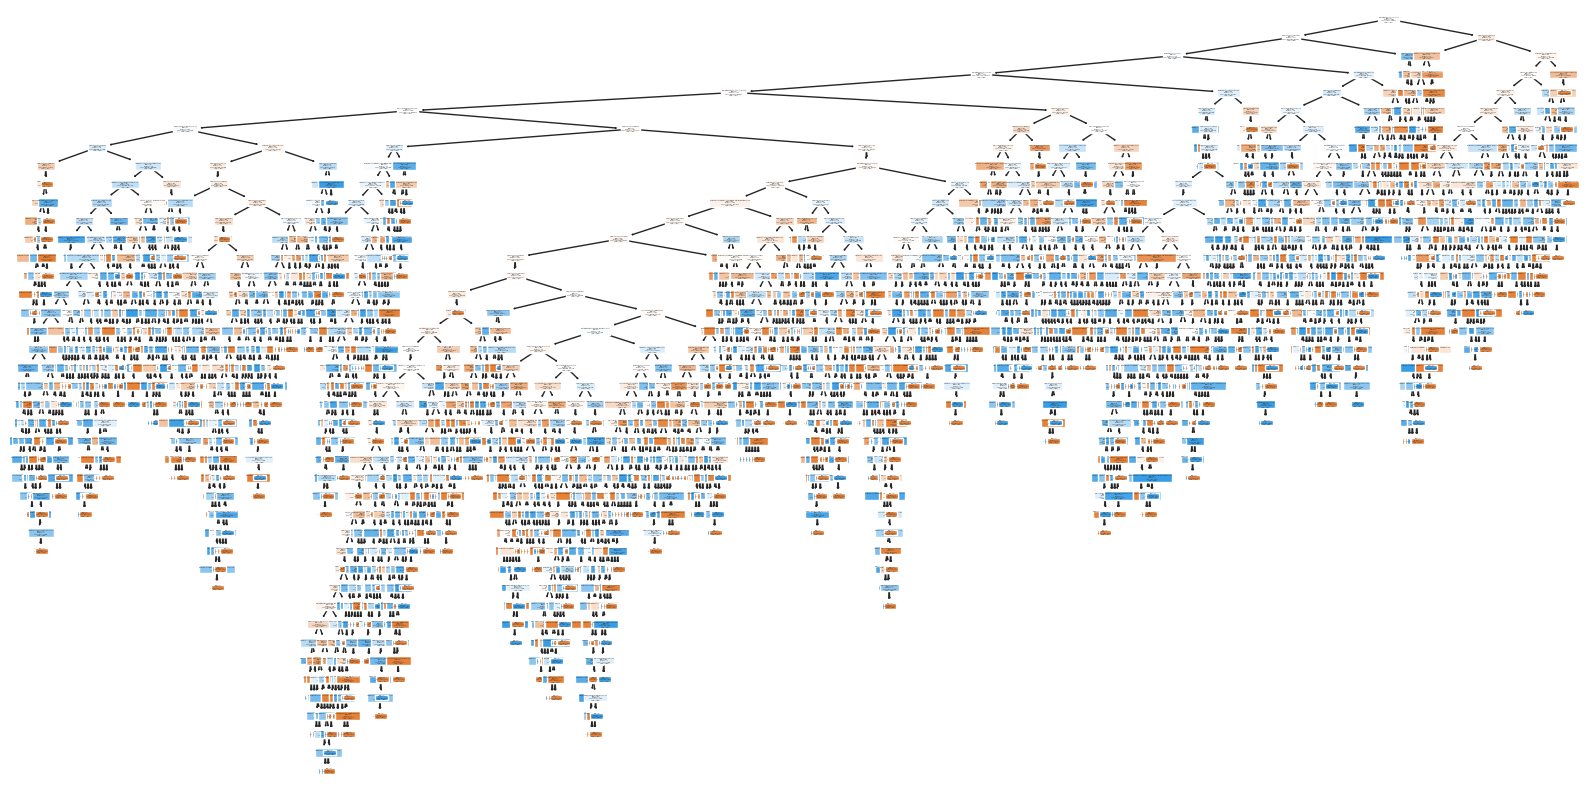

In [158]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=X.columns, class_names=['Illegal', 'Legal'], filled=True)
plt.show()

This decision tree shows many branches, demonstrating the complexity of the model.

I will use XG Boost to imporve the model

In [156]:
# 1. Import the XGBoost classifier
from xgboost import XGBClassifier

# 2. Import metrics to evaluate model performance
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 3. Calculate scale_pos_weight for class imbalance
# It’s calculated as: number of 0s / number of 1s
# You already found this from value_counts:
# 0 -> 7017, 1 -> 2983
scale_pos_weight = 7017 / 2983

# 4. Initialize the XGBoost model
xgb_model = XGBClassifier(
    use_label_encoder=False,       # Avoids warnings for label encoding
    eval_metric='logloss',         # Evaluation metric for binary classification
    scale_pos_weight=scale_pos_weight,  # Tells XGBoost to penalize class imbalance
    random_state=42                # For reproducibility
)

# 5. Train (fit) the model on the training data
xgb_model.fit(X_train, y_train)

# 6. Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# 7. Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("\n Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


Accuracy: 0.5635

 Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.67      0.68      1389
           1       0.30      0.31      0.31       611

    accuracy                           0.56      2000
   macro avg       0.49      0.49      0.49      2000
weighted avg       0.57      0.56      0.57      2000


Confusion Matrix:
 [[935 454]
 [419 192]]


**Closing Remarks on the Machine Learning Model**

Achieving 56% accuracy in identifying illegal transactions provides a reasonable starting point for model development, especially given the complexity and class imbalance in financial crime data. However, this result does not yet outperform the baseline model previously used.
The current model demonstrates limited effectiveness in flagging high-risk (illegal) transactions, largely due to the imbalance in the dataset and possibly insufficient feature engineering. With further refinement, including hyperparameter tuning, enhanced feature selection, and techniques to balance the dataset (such as SMOTE or class weights), performance can likely be improved.
In future iterations, more advanced models such as Random Forests, XGBoost, or ensemble approaches could be explored to increase both precision and recall for illegal transactions. Incorporating domain-specific knowledge and external risk indicators may also enhance predictive power.
Ultimately, while the model offers a foundational approach, its real value lies in demonstrating the potential for intelligent automation in anti-money laundering (AML). With further development, such models could meaningfully support compliance teams in identifying high-risk activity and prioritising investigations.